In [24]:
# imports
import fastf1 as ff1
from fastf1 import plotting
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.collections import LineCollection
from matplotlib import cm
import numpy as np
import pandas as pd


## Habilitando o plot, cache 


In [25]:

# arrumando o plotting
plotting.setup_mpl()

# habilitando o cache
ff1.Cache.enable_cache('G:/Faculdade/Ti/7º Semestre/cachef1') 

# tirando os warnings do panda
pd.options.mode.chained_assignment = None

# Coletando os dados

In [26]:
# carregando a sessão e a corrida
race = ff1.get_session(2021, 'Sao Paulo', 'R')

# carregando as voltas com a telemtria ativada
laps = race.load_laps(with_telemetry=True)

c:\Users\alexa\AppData\Local\Programs\Python\Python39\lib\site-packages\fastf1\core.py:1116: FutureWarning: `Session.load_laps` is deprecated and will beremoved in a future version.
Use `Session.load` instead.
  warnings.warn("`Session.load_laps` is deprecated and will be"
core           INFO 	Loading data for São Paulo Grand Prix - Race [v2.2.5]
api            INFO 	No cached data found for driver_info. Loading data...
api            INFO 	Fetching driver list...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_data. Loading data...
api            INFO 	Fetching timing data...
api            INFO 	Parsing timing data...
api            INFO 	Data has been written to cache!
api            INFO 	No cached data found for timing_app_data. Loading data...
api            INFO 	Fetching timing app data...
api            INFO 	Data has been written to cache!
core           INFO 	Processing timing data...
api            INFO 	No cached da

# Expandindo os dados
Carregamos todos os dados e agora vamos trabalhar com eles para deixar do jeito que queremos

In [27]:
# calcular o numero da volta tirando o aquecimento
# Calculate RaceLapNumber (LapNumber minus 1 since the warmup lap is included in LapNumber)
laps['RaceLapNumber'] = laps['LapNumber'] - 1

# no gp da russia começou a chover na volta 45
# Starting from lap 45 it started raining
laps = laps.loc[laps['RaceLapNumber'] >= 10]

Criamos a caomparação volta por volta para termos a telemtria, porém teremos que usar um loop para pegar as informações já que o fastf1 só deixa um piloto por vez

In [28]:
# selecionando todos os pilotos
drivers = pd.unique(laps['Driver'])

telemetry = pd.DataFrame()

# telemetria só pode ser um piloto por vez
for driver in drivers:
    driver_laps = laps.pick_driver(driver)
    
    # precisamos pegar a telemetria volta - volta
    for lap in driver_laps.iterlaps():
        driver_telemetry = lap[1].get_telemetry().add_distance()
        driver_telemetry['Driver'] = driver
        driver_telemetry['Lap'] = lap[1]['RaceLapNumber']
        driver_telemetry['Compound'] = lap[1]['Compound']
    
        telemetry = telemetry.append(driver_telemetry)

C:\Users\alexa\AppData\Local\Temp\ipykernel_3220\2204448494.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\Users\alexa\AppData\Local\Temp\ipykernel_3220\2204448494.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\Users\alexa\AppData\Local\Temp\ipykernel_3220\2204448494.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\Users\alexa\AppData\Local\Temp\ipykernel_3220\2204448494.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  telemetry = telemetry.append(driver_telemetry)
C:\U

Vamos selecionar as colunas que precisamos e convertemos os compostos "Duro", "médio" e "macio" para liso

In [29]:
# deixando apenas as colunas que precisamos
telemetry = telemetry[['Lap', 'Distance', 'Compound', 'Speed', 'X','Y']]

# Tudo que não for intermediario será considerado liso
telemetry['Compound'].loc[telemetry['Compound'] != 'INTERMEDIATE'] = 'SLICK'

# Criar minisetores para calcular o composto mais rápido

## Vamos dividir igualmente a volta em 25 mini setores (lap distance / 25)
## Vamos atribuir em cada linha dos dados da telemtria com qual mini setor o piloto está
## Nós agrupamos por volta, mini setor, composto e velocidade média para podermos ver qual o pneu mais forte durante aquele ponto da volta

### primeiro criamos os mini setores

In [30]:

# queremos 25 setores 
num_minisectors = 25

# calcular a distância da volta
total_distance = max(telemetry['Distance'])

# criando peças iguais
minisector_length = total_distance / num_minisectors

minisectors = [0]

for i in range(0, (num_minisectors - 1)):
    minisectors.append(minisector_length * (i + 1))

### Atribuimos o mini setor atual para cada linha dos dados da telemetria

In [31]:
# atribuindo os minisetores para cada coluna dos dados da telemetria
telemetry['Minisector'] =  telemetry['Distance'].apply(
  lambda z: (
    minisectors.index(
      min(minisectors, key=lambda x: abs(x-z)))+1
  )
)

### Nós criamos a coluna mini setor na tabela da telemetria, que roda um calculo baseado no que está armazenado na coluna distância. Baseado na distância, podemos ver qual posição do indice dentro do mini setor a distância pertence.

### O numero do indice é o número do mini setor

## Agora podemos calcular a velocidade média pelo mini setor, nós agrupamos por volta, mini setor e composto

In [32]:
# calculando o pneu mais rapido por mini setor
average_speed = telemetry.groupby(['Lap', 'Minisector', 'Compound'])['Speed'].mean().reset_index()


### Usando esses dados nós selecionamos o composto mais rápido por setor

In [33]:
# selecionando o composto com a maio velocidade média
fastest_compounds = average_speed.loc[average_speed.groupby(['Lap', 'Minisector'])['Speed'].idxmax()]

# retirando a coluna de velocidade e renomeando a coluna do composto
fastest_compounds = fastest_compounds[['Lap', 'Minisector', 'Compound']].rename(columns={'Compound': 'Fastest_compound'})


### Agora vamos unir a telemetria com o composto mais rápido por setor, e ordenamos os dados da telemetria por distância 

In [34]:
# adicionando o composto mais rapido por mini setor com a telemtria completa
telemetry = telemetry.merge(fastest_compounds, on=['Lap', 'Minisector'])

# ordenando os dados 
telemetry = telemetry.sort_values(by=['Distance'])

# transformando em inteiros
telemetry.loc[telemetry['Fastest_compound'] == "INTERMEDIATE", 'Fastest_compound_int'] = 1
telemetry.loc[telemetry['Fastest_compound'] == "SLICK", 'Fastest_compound_int'] = 2

Plotando os dados

In [35]:
def generate_minisector_plot(lap, save=False, details=True):
    single_lap = telemetry.loc[telemetry['Lap'] == lap]

    x = np.array(single_lap['X'].values)
    y = np.array(single_lap['Y'].values)

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    compound = single_lap['Fastest_compound_int'].to_numpy().astype(float)

    cmap = cm.get_cmap('ocean', 2)
    lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
    lc_comp.set_array(compound)
    lc_comp.set_linewidth(2)

    plt.rcParams['figure.figsize'] = [12, 5]
    
    if details:
        title = plt.suptitle(
            f"2021 Russian GP \n Lap {lap} - Slicks vs. Inters"
        )
        
    plt.gca().add_collection(lc_comp)
    plt.axis('equal')
    plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
    
    if details:
        cbar = plt.colorbar(mappable=lc_comp, boundaries=np.arange(1, 4))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(['Inters', 'Slicks'])
    
    if save:
        plt.savefig(f"G:/Faculdade/minisectors_lap_{lap}.png", dpi=300)

    plt.show()

Chamando o método

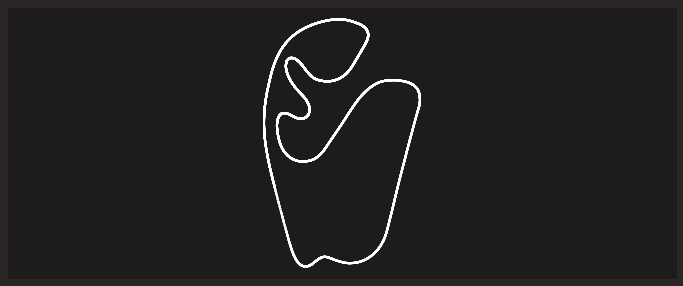

In [36]:

generate_minisector_plot(32, save=True, details=False)